<a href="https://colab.research.google.com/github/sokdnv/project_1/blob/main/notebooks/IIC_ResNet50_08_05_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Фаза 2 • Неделя 8 • Пятница
## Нейронные сети
### Распознавание Intel Image Classification на ResNet50

In [2]:
!pip -qq install torchutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 12.9 MB/s eta 0:00:00


In [96]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

# Для чтения изображений с диска
from torchvision import io # input/output
from torchvision.models import resnet50, ResNet50_Weights
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import os

In [97]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


## Fine Tuning

Теперь обучим модель под свою задачу – сделаем **fine-tuning**. Возьмем `resnet18` для скорости – он намного меньше.

In [98]:
# Создаем класс модели нейронки на основе ResNet50

class MyResNet50(nn.Module):
    def __init__(self):
        super().__init__()

        # подгружаем базовую модель ResNet50
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        # заменяем выходной слой - на выходе 6 классов
        self.model.fc = nn.Linear(2048, 6)
        # замораживаем все слои
        for i in self.model.parameters():
            i.requires_grad = False
        # размораживаем последний слой - для обучения
        self.model.fc.weight.requires_grad = True
        self.model.fc.bias.requires_grad = True

    def forward(self, x):
        return self.model(x)


model = MyResNet50()
model.to(DEVICE);

In [99]:
fake_batch = torch.randn(1, 3, 150, 150, device=DEVICE)
tu.get_model_summary(model, fake_batch)

Layer                                               Kernel              Output          Params          FLOPs
0_model.Conv2d_conv1                               [3, 64, 7, 7]     [1, 64, 75, 75]       9,408   52,920,000
1_model.BatchNorm2d_bn1                                     [64]     [1, 64, 75, 75]         128    1,440,000
2_model.ReLU_relu                                              -     [1, 64, 75, 75]           0            0
3_model.MaxPool2d_maxpool                                      -     [1, 64, 38, 38]           0            0
4_model.layer1.0.Conv2d_conv1                     [64, 64, 1, 1]     [1, 64, 38, 38]       4,096    5,914,624
5_model.layer1.0.BatchNorm2d_bn1                            [64]     [1, 64, 38, 38]         128      369,664
6_model.layer1.0.ReLU_relu                                     -     [1, 64, 38, 38]           0            0
7_model.layer1.0.Conv2d_conv2                     [64, 64, 3, 3]     [1, 64, 38, 38]      36,864   53,231,616
8_model.la

In [108]:
# Проверка настроек последнего слоя
print(model.model.fc)
print(model.model.fc.bias.requires_grad)

Linear(in_features=2048, out_features=6, bias=True)
True


In [21]:
# Распаковываем архив
zip_path = 'iic_archive.zip'
extract_to = './data/'
os.makedirs(extract_to, exist_ok=True)

!unzip -q {zip_path} -d {extract_to}

In [109]:
# Делаем трансформации, которые подразумевает модель:
# она обучалась на изображениях такого формата
train_transforms = T.Compose([
    # T.RandomRotation(180),
    # T.RandomHorizontalFlip(p=.5),
    # T.ColorJitter(brightness=.5, contrast=.5, saturation=.5, hue=.5),
    # T.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
    T.Resize((150, 150)),  # Изменение размера изображений
    T.ToTensor(),  # Конвертация изображений в тензоры
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация
])

# Преобразования для валидационных данных
valid_transforms = T.Compose([
    T.Resize((150, 150)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [110]:
# Про ImageFolder
# читаем тут: https://elbrus-ds-cheatsheets.streamlit.app/PyTorch_Datasets
train_dataset = torchvision.datasets.ImageFolder(
    'data/seg_train/seg_train',
    transform=train_transforms
)
valid_dataset = torchvision.datasets.ImageFolder(
    'data/seg_test/seg_test',
    transform=valid_transforms
)

In [26]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: data/seg_train/seg_train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-180.0, 180.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.5, 0.5))
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [111]:
train_dataset.class_to_idx

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [112]:
# Словарь для определения класса по индексу
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}
idx2class

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [113]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [114]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = torch.nn.CrossEntropyLoss()

In [123]:
n_epochs = 1
train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc =[]
for epoch in range(n_epochs):
    model.train()
    loss_batch = []
    acc_batch  = []

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images)

        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_batch.append(loss.item())
        _, predicted = torch.max(preds, 1)
        acc_batch.append((predicted == labels).sum().item() / labels.size(0))

    train_epoch_losses.append(sum(loss_batch) / len(loss_batch))
    train_epoch_acc.append(sum(acc_batch) / len(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(images)

            loss = criterion(preds, labels)
            loss_batch.append(loss.item())

            _, predicted = torch.max(preds, 1)
            acc_batch.append((predicted == labels).sum().item() / labels.size(0))

    valid_epoch_losses.append(sum(loss_batch) / len(loss_batch))
    valid_epoch_acc.append(sum(acc_batch) / len(acc_batch))

    print(f'---------- Epoch: {epoch+1} ----------')
    print(f'loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}')
    print(f'accuracy_train: {train_epoch_acc[-1]:.3f}, accuracy_valid: {valid_epoch_acc[-1]:.3f}')

print("Training complete")

---------- Epoch: 1 ----------
loss_train: 0.184, loss_valid: 0.291
accuracy_train: 0.931, accuracy_valid: 0.893
Training complete


---------- Epoch: 1 ----------
loss_train: 0.192, loss_valid: 0.289
accuracy_train: 0.931, accuracy_valid: 0.902
---------- Epoch: 2 ----------
loss_train: 0.187, loss_valid: 0.307
accuracy_train: 0.929, accuracy_valid: 0.888
Training complete

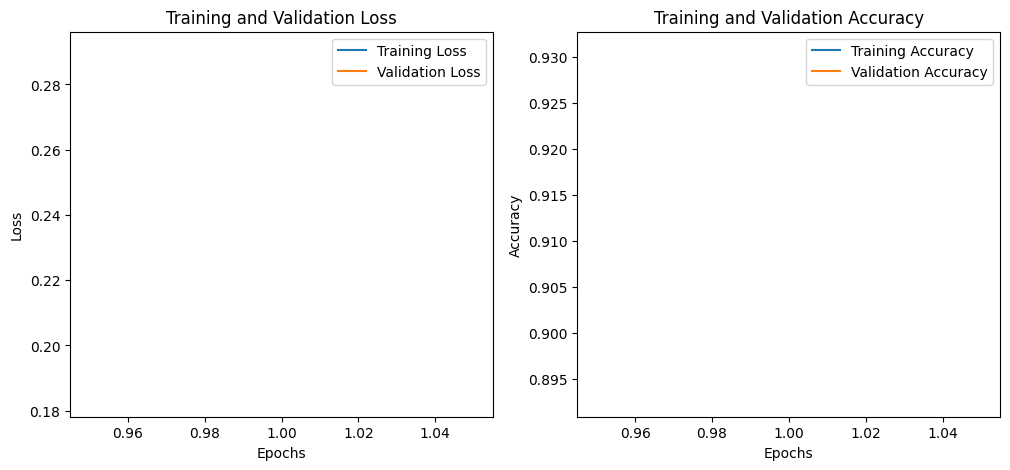

In [124]:
epochs = range(1, len(train_epoch_acc) + 1)

plt.figure(figsize=(12, 5))

# График Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_epoch_losses, label='Training Loss')
plt.plot(epochs, valid_epoch_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# График Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_epoch_acc, label='Training Accuracy')
plt.plot(epochs, valid_epoch_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [125]:
resize = T.Resize((150, 150))

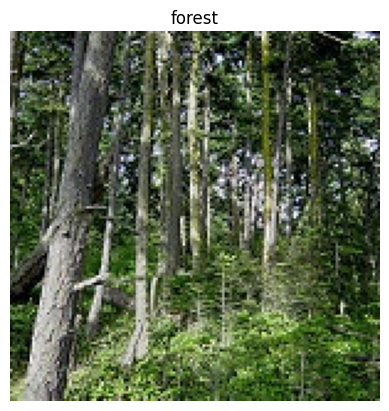

In [127]:
img = resize(io.read_image('./data/seg_pred/seg_pred/10292.jpg')/255)  # Убедитесь, что размер изображения соответствует входному размеру модели
plt.imshow(torch.permute(img, (1, 2, 0)))

with torch.inference_mode():
    # pred_class = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE))).round().item()
    preds = model(img.unsqueeze(0).to(DEVICE))
    pred_class = torch.argmax(preds, dim=1).item()

plt.axis('off')
plt.title(idx2class[pred_class]);
plt.show()

# print(f"Predicted class: {idx2class[pred_class]}")

## Saving and Loading models

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_1 = nn.Linear(33, 1)
        self.fc_2 = nn.Linear(33, 2)

    def forward(self, x):
        out = self.fc_1(x)
        out = self.fc_2(out)
        return out

In [ ]:
model = Model()

In [ ]:
# fit
# eval
# test

In [122]:
model.state_dict()

OrderedDict([('model.conv1.weight',
              tensor([[[[-7.4457e-03, -3.1783e-03,  3.7353e-02,  ...,  4.7936e-02,
                         -2.0325e-02,  8.8140e-03],
                        [-5.7435e-02,  4.4709e-02,  7.7509e-02,  ...,  8.8442e-02,
                          2.9346e-02, -5.8331e-02],
                        [ 6.8356e-02, -2.7044e-01,  4.0348e-01,  ..., -1.6491e-01,
                          2.1868e-01, -7.2909e-02],
                        ...,
                        [-1.0874e-01,  3.8148e-01, -4.5487e-01,  ...,  6.8366e-01,
                         -5.7855e-01,  2.2461e-01],
                        [ 2.5698e-02, -1.7703e-01,  6.4375e-01,  ...,  5.2644e-01,
                         -4.9317e-02, -6.8082e-02],
                        [ 4.5281e-02, -1.3072e-01,  1.7864e-02,  ..., -3.5753e-01,
                          1.8976e-01, -2.2302e-02]],
              
                       [[ 8.9197e-03,  4.8768e-03, -1.5356e-02,  ...,  8.6949e-02,
                         -

In [ ]:
torch.save(model.state_dict(), 'weights.pt')

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_1 = nn.Linear(32, 1)
        self.fc_2 = nn.Linear(33, 2)

    def forward(self, x):
        out = self.fc_1(x)
        out = self.fc_2(out)
        return out

model = Model()

In [ ]:
model.load_state_dict(torch.load('weights.pt'))

RuntimeError: Error(s) in loading state_dict for Model:
	size mismatch for fc_1.weight: copying a param with shape torch.Size([1, 33]) from checkpoint, the shape in current model is torch.Size([1, 32]).

In [ ]:
model.state_dict()

OrderedDict([('fc_1.weight',
              tensor([[ 0.0227,  0.1136, -0.0866,  0.0430,  0.0083, -0.1334,  0.1403,  0.1227,
                       -0.0929,  0.0042, -0.1311,  0.0808, -0.0992, -0.1009, -0.0477, -0.0237,
                       -0.0250,  0.1005, -0.0146, -0.1253, -0.0449,  0.1402,  0.0257,  0.0096,
                       -0.1062, -0.0928,  0.0714, -0.1473,  0.1518,  0.1081,  0.1480,  0.1619,
                       -0.1129]])),
             ('fc_1.bias', tensor([0.0803])),
             ('fc_2.weight',
              tensor([[-0.1323,  0.0147, -0.0850, -0.0103, -0.0205,  0.1216, -0.1073,  0.1660,
                       -0.1730,  0.0032,  0.1019,  0.1479, -0.0664,  0.1189,  0.0306,  0.1615,
                        0.1403,  0.0437,  0.1213,  0.1699,  0.0656,  0.0407, -0.1497,  0.0773,
                        0.1435, -0.1050, -0.0976, -0.1487,  0.0012, -0.0013, -0.0105,  0.0534,
                       -0.1547],
                      [-0.1573, -0.0901,  0.1206, -0.0951, -0.0844,

In [ ]:
def preprocess_model():
    mob_model = mobilenet_v3_small()
    mob_model.classifier[3] = nn.Linear(1024, 1)
    mob_model.load_state_dict(...)
    mob_model.eval()
    return mob_model